Customize: Custom Mask
======================

This example demonstrates how to load and use a custom mask from your hard-disk and use this as the mask in a pipeline.

The benefits of doing this are:

 - It can give significant gains in computational run-times, if large regions of the image which do not contain a
      signal are removed and processing time is not dedicated to fitting them.

 - For lens datasets with complex lens galaxies morphologies which are difficult to subtract cleanly, their
      residuals can negatively impact the mass model and source reconstruction. Custom masks can remove these features.

The drawbacks of doing this are:

 - The pixels that are removed which contain no source flux can still constrain the lens model. For example, a mass
      model may incorrectly predict flux in the source reconstruction where there is non observed, however the model-fit
      does not penalize this incorrect solution because this region of the image was masked and removed.

 - You cannot model the lens galaxy's light using a mask which remove most of its like, so this only works for
      images where the lens galaxy is already subtracted!

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autofit as af
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


I`ll assume that you are familiar with the beginner example scripts work, so if any code doesn`t make sense familiarize
yourself with those first!

In [2]:
dataset_name = "mass_sie__source_sersic"
pixel_scales = 0.1

dataset_path = path.join("dataset", "imaging", "no_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    pixel_scales=pixel_scales,
)

Okay, we need to load the mask from a .fits file, in the same fashion as the `Imaging` above. To draw a mask for an 
image, checkout the tutorial:

 `autolens_workspace/notebooks/preprocess/imaging/p4_mask.ipynb`

The example autolens_workspace dataset comes with a mask already, if you look in
`autolens_workspace/dataset/imaging/no_lens_light/mass_sie__source_sersic` you`ll see a mask.fits file!

In [3]:
mask_custom = al.Mask2D.from_fits(
    file_path=path.join(dataset_path, "mask_gui.fits"), hdu=0, pixel_scales=pixel_scales
)

When we plot the `Imaging` dataset with the mask it extracts only the regions of the image in the mask remove c
ontaminating bright sources away from the lens and zoom in around the mask to emphasize the lens.

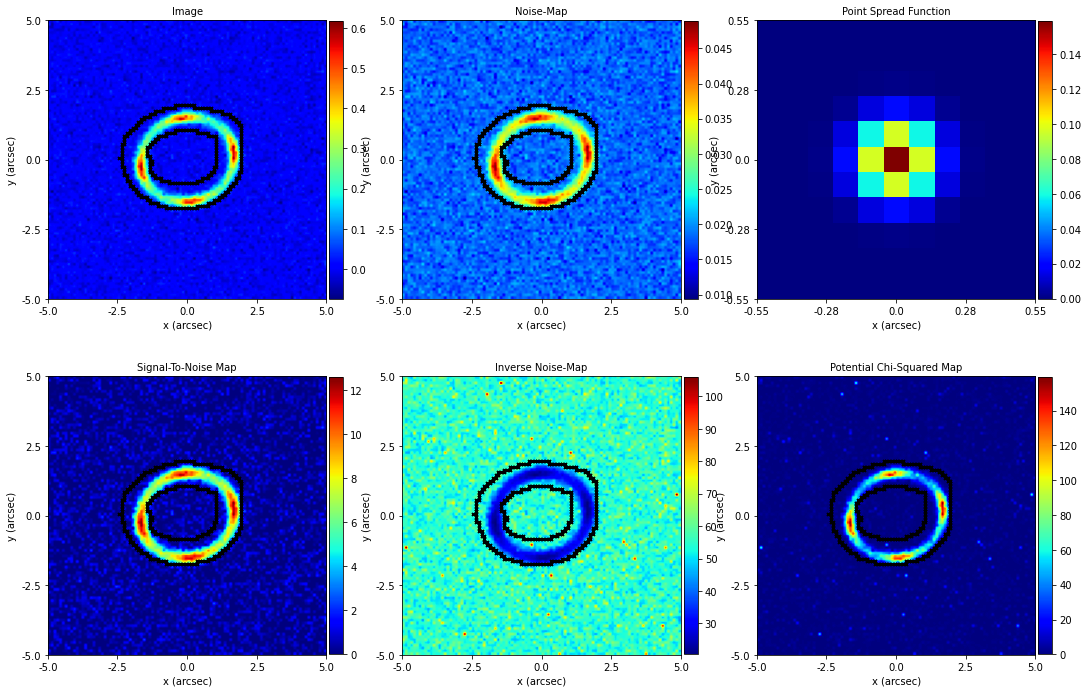

In [4]:
visuals_2d = aplt.Visuals2D(mask=mask_custom)

imaging_plotter = aplt.ImagingPlotter(imaging=imaging, visuals_2d=visuals_2d)
imaging_plotter.subplot_imaging()

__Model__

we'll fit a `EllipticalIsothermal` + `EllipticalSersic` model which we often fitted in the beginner example scripts.

In [5]:
lens = af.Model(al.Galaxy, redshift=0.5, mass=al.mp.EllipticalIsothermal)
source = af.Model(al.Galaxy, redshift=1.0, bulge=al.lp.EllipticalSersic)

__Search__

we'll use the default `DynestyStatic` sampler we used in the beginner examples.

The `name` and `path_prefix` below specify the path where results are stored in the output folder:  

 `/autolens_workspace/output/imaging/modeling/customize/mass_sie__source_sersic/phase__custom_mask`.
    
Note that we pass the phase run function our custom mask, which means it is used to perform the model-fit!

In [6]:
search = af.DynestyStatic(
    path_prefix=path.join("imaging", "customize", dataset_name),
    name="phase_custom_mask",
    n_live_points=50,
)

__Settings__

Next, we specify the `SettingsPhaseImaging`, which in this example simmply use the default values used in the beginner
examples.

In [7]:
settings = al.SettingsPhaseImaging()

__Phase__

We can now combine the model, settings and search to create and run a phase, fitting our data with the lens model.

In [8]:
phase = al.PhaseImaging(
    galaxies=af.Collection(lens=lens, source=source),
    settings=settings,
    search=search,
)

phase.run(dataset=imaging, mask=mask_custom)

INFO:root:phase_custom_mask already completed, skipping non-linear search.


Finish.